In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.__stdout__

In [2]:
import tensorflow as tf
# data
(x_train, y_train), (x_test, y_test) = \
    tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = np.squeeze(y_train) # (60000,)
x_test = x_test.astype('float32')
y_test = np.squeeze(y_test) # (10000,)
x_train /= 255
x_test /= 255
x_train = (x_train > 0.5).astype(np.float32)
x_test = (x_test > 0.5).astype(np.float32)

In [3]:
def get_digits(x, y, num, digit=[[1], [2], [3]]):
    where_arg = np.bitwise_or.reduce(y == digit, axis=0)
    digit_idx = np.where(where_arg)[0]
    digit_idx = digit_idx[:num]
    x = x[digit_idx]
    y = y[digit_idx]
    return x, y

def add_shot_noise(image, rng):
    # randomly flip the pixel with probability 0.2
    
    image = image.reshape(784)
    
    # if s==1 then flip;
    # `image + 0.5*s` stratify `image` pixel into {0, 0.5, 1, 1.5}
    # 0.5 indicates the value needs to be fliped to 1
    # 1.5 indicates the value needs to be fliped to 0
    s = 0.5 * rng.binomial(1, 0.2, 784)
    tmp_img = image + s
    flip_zero_idx = np.where(tmp_img == 0.5)[0]
    flip_one_idx = np.where(tmp_img == 1.5)[0]
    tmp_img[flip_zero_idx] = 1.
    tmp_img[flip_one_idx] = 0.
    return tmp_img

In [4]:
# small healing mnist

# 1. select first example digit 1 and 5 in the dataset as prototype;
# 2. add flip-bit noise to the pixels of the two digit examples; repeat 20000 times for each digit;
# 3. 40000 size dataset with each digit 1 and digit 5

data_size_per_digit = 20000
rng = np.random.RandomState(1234)
tr_data, te_data = [], []


def get_noisy_digits(digit):
    # first digit in the dataset as a prototype
    d_tr, _ = get_digits(x_train, y_train, num=1, digit=digit)
    d_te, _ = get_digits(x_test, y_test, num=1, digit=digit)

    for i in range(data_size_per_digit):
        tr_data.append(add_shot_noise(d_tr, rng))
        te_data.append(add_shot_noise(d_te, rng))
        
get_noisy_digits([[1]])
get_noisy_digits([[5]])

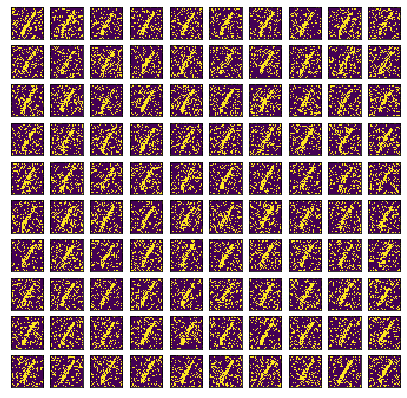

In [5]:
# samples
fig = plt.Figure(figsize=(7,7))
axes = fig.subplots(10,10)

for i in range(10):
    for j in range(10):
        ax = axes[i,j]
        
        x = tr_data[i*10+j]
        
        ax.imshow(x.reshape(28,28))
        ax.set_xticks([])
        ax.set_xticks([], minor=True)
        ax.set_yticks([])
        ax.set_yticks([], minor=True)

fig

In [6]:
np.save('dataset/small_healing_mnist_tr.npy', tr_data)
np.save('dataset/small_healing_mnist_te.npy', te_data)